
# Telco Customer Churn Prediction Using Machine Learning 


# 1. Business Understanding


Problem Statement

Customer attrition (churn) is a significant concern for businesses as it directly impacts revenue and growth. Understanding the factors influencing churn and predicting it accurately can help organizations implement proactive retention strategies.

Goals and Objectives

    Goal: 
Develop a machine learning model to predict customer churn.

    Objectives:
Identify key indicators of churn.
Build a model with high accuracy, precision, and recall.
Provide actionable insights to reduce churn rate.

Hypothesis (Null and Alternative)

    Null Hypothesis (H0): 
There is no significant relationship between customer attributes (demographics etc.) and churn.
    Alternative Hypothesis (H1): 
Specific customer attributes significantly influence churn rates.

Analytical Questions
1. How do different customer attributes (e.g. demographs) influence churn?
2. Which services (e.g., internet type, contract terms) are associated with higher churn rates?
3. Can payment methods affect customer retention?
4. Is there a correlation between tenure and churn rate?
    

In [1]:
# Connection packages
import os
import pyodbc  
from dotenv import dotenv_values    #import the dotenv_values function from the dotenv package

# Data handling
import pandas as pd
import numpy as np
import warnings 

# EDA 

#import ydata_profiling as pp

# Hypothesis testing
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

# Vizualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Feature processing
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, LabelEncoder, PowerTransformer
from sklearn.model_selection import train_test_split
#from imblearn.over_sampling import SMOTE  # For balancing the dataset

# Modelling
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

# Computations
import math

# Warnings
warnings.filterwarnings('ignore')


### Server Connection

In [2]:
# Load environment variables from .env file into a dictionary

environment_variables = dotenv_values('.env')

# Get the values for the credentials you set in the '.env' file

server = environment_variables.get("SERVER")
database = environment_variables.get("DATABASE")
username = environment_variables.get("USERNAME")
password = environment_variables.get("PASSWORD")

In [3]:
# Create a connection string

connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password};MARS_Connection=yes;MinProtocolVersion=TLSv1.2;"

In [ ]:
# Use the connect method of the pyodbc library and pass in the connection string

connection = pyodbc.connect(connection_string)

connection.timeout = 60 

### First Dataset

In [ ]:
# Fetching sql query

query = "SELECT * FROM LP2_Telco_churn_first_3000"

data = pd.read_sql(query, connection)

In [ ]:
data.head()

In [ ]:
# Save dataFrame to CSV

first_3000 = 'LP2_Telco_churn_first_3000.csv'
data.to_csv(first_3000, index=False)

In [ ]:
# Read the CSV file into a DataFrame

first_3000_data = pd.read_csv(first_3000)

In [ ]:
# Display the first few rows of the DataFrame directly

first_3000_data.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,False,True,False,1,False,NaN,DSL,False,...,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.850000,False
1,5575-GNVDE,Male,False,False,False,34,True,False,DSL,True,...,True,False,False,False,One year,False,Mailed check,56.950001,1889.500000,False
2,3668-QPYBK,Male,False,False,False,2,True,False,DSL,True,...,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,7795-CFOCW,Male,False,False,False,45,False,NaN,DSL,True,...,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.750000,False
4,9237-HQITU,Female,False,False,False,2,True,False,Fiber optic,False,...,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True


In [ ]:
first_3000_data.shape

(3000, 21)

### Second Dataset

In [ ]:

second_2000_data = pd.read_csv('LP2_Telco-churn-second-2000.csv')
second_2000_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,5600-PDUJF,Male,0,No,No,6,Yes,No,DSL,No,...,No,Yes,No,No,Month-to-month,Yes,Credit card (automatic),49.50,312.7,No
1,8292-TYSPY,Male,0,No,No,19,Yes,No,DSL,No,...,Yes,Yes,No,No,Month-to-month,Yes,Credit card (automatic),55.00,1046.5,Yes
2,0567-XRHCU,Female,0,Yes,Yes,69,No,No phone service,DSL,Yes,...,Yes,No,No,Yes,Two year,Yes,Credit card (automatic),43.95,2960.1,No
3,1867-BDVFH,Male,0,Yes,Yes,11,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,74.35,834.2,Yes
4,2067-QYTCF,Female,0,Yes,No,64,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,111.15,6953.4,No


In [ ]:
second_2000_data.shape

(2043, 21)

### Concatenate Datasets

In [ ]:
# Concatenate the two datasets

# Concatenate based on customerID column
combined_data = pd.concat([first_3000_data.set_index('customerID'), second_2000_data.set_index('customerID')])

# Reset index to make customerID a regular column again
combined_data.reset_index(inplace=True)

combined_data.shape


In [ ]:
# Save the concatenated datasets into a csv format 

combined_data.to_csv('combined_data.csv', index=False)


In [ ]:
combined_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,True,False,1,False,NaN,DSL,False,...,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.85,False
1,5575-GNVDE,Male,0,False,False,34,True,False,DSL,True,...,True,False,False,False,One year,False,Mailed check,56.950001,1889.5,False
2,3668-QPYBK,Male,0,False,False,2,True,False,DSL,True,...,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,7795-CFOCW,Male,0,False,False,45,False,NaN,DSL,True,...,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.75,False
4,9237-HQITU,Female,0,False,False,2,True,False,Fiber optic,False,...,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True



# 2. Data Understanding

## Exploratory Data Analysis

###    1. Understanding The Data

In [2]:
combined_data = pd.read_csv('combined_data.csv')

In [3]:
combined_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,True,False,1,False,NaN,DSL,False,...,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.850000381469727,False
1,5575-GNVDE,Male,0,False,False,34,True,False,DSL,True,...,True,False,False,False,One year,False,Mailed check,56.950001,1889.5,False
2,3668-QPYBK,Male,0,False,False,2,True,False,DSL,True,...,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.1500015258789,True
3,7795-CFOCW,Male,0,False,False,45,False,NaN,DSL,True,...,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.75,False
4,9237-HQITU,Female,0,False,False,2,True,False,Fiber optic,False,...,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.64999389648438,True


In [4]:
combined_data.tail()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
5038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
5039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
5040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
5041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes
5042,3186-AJIEK,Male,0,No,No,66,Yes,No,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),105.65,6844.5,No


#### Standardize The Columns

In [5]:
#Standardizing the True and False values

# Standardize function

def standardize_values(df, column, true_values, false_values):
    df[column] = df[column].replace(true_values, 'Yes')
    df[column] = df[column].replace(false_values, 'No')

# List of columns to standardize
columns_to_standardize = [
    'Churn', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
    'StreamingTV', 'StreamingMovies', 'PaperlessBilling'
]

# Values that represent True/Yes and False/No
true_values = ['True', 'Yes', 'yes', 'true']
false_values = ['False', 'No', 'no', 'false']

# Apply standardization
for column in columns_to_standardize:
    standardize_values(combined_data, column, true_values, false_values)

# Verify changes
for column in columns_to_standardize:
    print(f"{column}: {combined_data[column].unique()}")


Churn: ['No' 'Yes' nan]
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
PhoneService: ['No' 'Yes']
MultipleLines: [nan 'No' 'Yes' 'No phone service']
OnlineSecurity: ['No' 'Yes' nan 'No internet service']
OnlineBackup: ['Yes' 'No' nan 'No internet service']
DeviceProtection: ['No' 'Yes' nan 'No internet service']
TechSupport: ['No' 'Yes' nan 'No internet service']
StreamingTV: ['No' 'Yes' nan 'No internet service']
StreamingMovies: ['No' 'Yes' nan 'No internet service']
PaperlessBilling: ['Yes' 'No']


#### Identifying Missing Values

In [6]:

# Count NaN values in each column
nan_counts = combined_data.isna().sum()

# Filter and print columns with NaN values
nan_columns = nan_counts[nan_counts > 0]
print("\nColumns with NaN values and their counts:")
print(nan_columns)


Columns with NaN values and their counts:
MultipleLines       269
OnlineSecurity      651
OnlineBackup        651
DeviceProtection    651
TechSupport         651
StreamingTV         651
StreamingMovies     651
TotalCharges          5
Churn                 1
dtype: int64


In [7]:
columns = combined_data.columns

In [8]:
# Unique values in each column
for column in columns:
    print(f'{column}')
    print(f'There are {combined_data[column].unique().size} unique values')
    print(f'These are {combined_data[column].unique()}')
    print('=' * 50)

customerID
There are 5043 unique values
These are ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
gender
There are 2 unique values
These are ['Female' 'Male']
SeniorCitizen
There are 2 unique values
These are [0 1]
Partner
There are 2 unique values
These are ['Yes' 'No']
Dependents
There are 2 unique values
These are ['No' 'Yes']
tenure
There are 73 unique values
These are [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
PhoneService
There are 2 unique values
These are ['No' 'Yes']
MultipleLines
There are 4 unique values
These are [nan 'No' 'Yes' 'No phone service']
InternetService
There are 3 unique values
These are ['DSL' 'Fiber optic' 'No']
OnlineSecurity
There are 4 unique values
These are ['No' 'Yes' nan 'No internet service']
OnlineBackup
There are 4 unique values
These a

In [9]:
combined_data.shape

(5043, 21)

#### Overview After Standardization

In [10]:
#Overview 

combined_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,NaN,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.850000,29.850000381469727,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.950001,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.849998,108.1500015258789,Yes
3,7795-CFOCW,Male,0,No,No,45,No,NaN,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.299999,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.699997,151.64999389648438,Yes


In [11]:
# Overview 
combined_data.tail()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
5038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
5039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
5040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
5041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes
5042,3186-AJIEK,Male,0,No,No,66,Yes,No,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),105.65,6844.5,No


In [12]:
combined_data.describe(include = 'all')

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
count,5043,5043,5043.000000,5043,5043,5043.000000,5043,4774,5043,4392,...,4392,4392,4392,4392,5043,5043,5043,5043.000000,5038,5042
unique,5043,2,NaN,2,2,NaN,2,3,3,3,...,3,3,3,3,3,2,4,NaN,4870,2
top,7590-VHVEG,Male,NaN,No,No,NaN,Yes,No,Fiber optic,No,...,No,No,No,Yes,Month-to-month,Yes,Electronic check,NaN,20.450000762939453,No
freq,1,2559,NaN,2585,3482,NaN,4554,2424,2248,2507,...,2219,2472,2018,1982,2744,2996,1700,NaN,5,3706
mean,NaN,NaN,0.162403,NaN,NaN,32.576641,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.090214,NaN,NaN
std,NaN,NaN,0.368857,NaN,NaN,24.529807,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.068133,NaN,NaN
min,NaN,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.400000,NaN,NaN
25%,NaN,NaN,0.000000,NaN,NaN,9.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.775000,NaN,NaN
50%,NaN,NaN,0.000000,NaN,NaN,29.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.550003,NaN,NaN
75%,NaN,NaN,0.000000,NaN,NaN,56.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,90.050003,NaN,NaN


In [13]:
combined_data.nunique()

customerID          5043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      2069
TotalCharges        4870
Churn                  2
dtype: int64

#### Checking Duplicates

In [14]:
combined_data[combined_data.duplicated()]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn


#### Checking Data Types

In [15]:
combined_data.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

#### Modify Data Types

In [16]:
combined_data.TotalCharges = pd.to_numeric(combined_data.TotalCharges, errors='coerce')
combined_data.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

#### General Overview With Profile Report

In [17]:
'''
# Use pandas_profiling.ProfileReport method

pp.ProfileReport(combined_data)
'''

'\n# Use pandas_profiling.ProfileReport method\n\npp.ProfileReport(combined_data)\n'

####    2.Data Quality Assessment 
#####        a. Checking Missing Values


In [18]:
combined_data.isna().sum()

customerID            0
gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines       269
InternetService       0
OnlineSecurity      651
OnlineBackup        651
DeviceProtection    651
TechSupport         651
StreamingTV         651
StreamingMovies     651
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          8
Churn                 1
dtype: int64

#####        b.Detecting Outliers

In [19]:
# Detection through boxplots

def outlier_check_boxplot(df,numerical_values):
    number_of_columns = 2
    number_of_rows = math.ceil(len(numerical_values)/2)
    
    fig = plt.figure(figsize=(12,5*number_of_rows))
    for index, column in enumerate(numerical_values, 1):
        ax = fig.add_subplot(number_of_rows, number_of_columns, index)
        ax = sns.boxplot(x = column, data = df, palette = "Blues")
        ax.set_title(column)
    return plt.show()

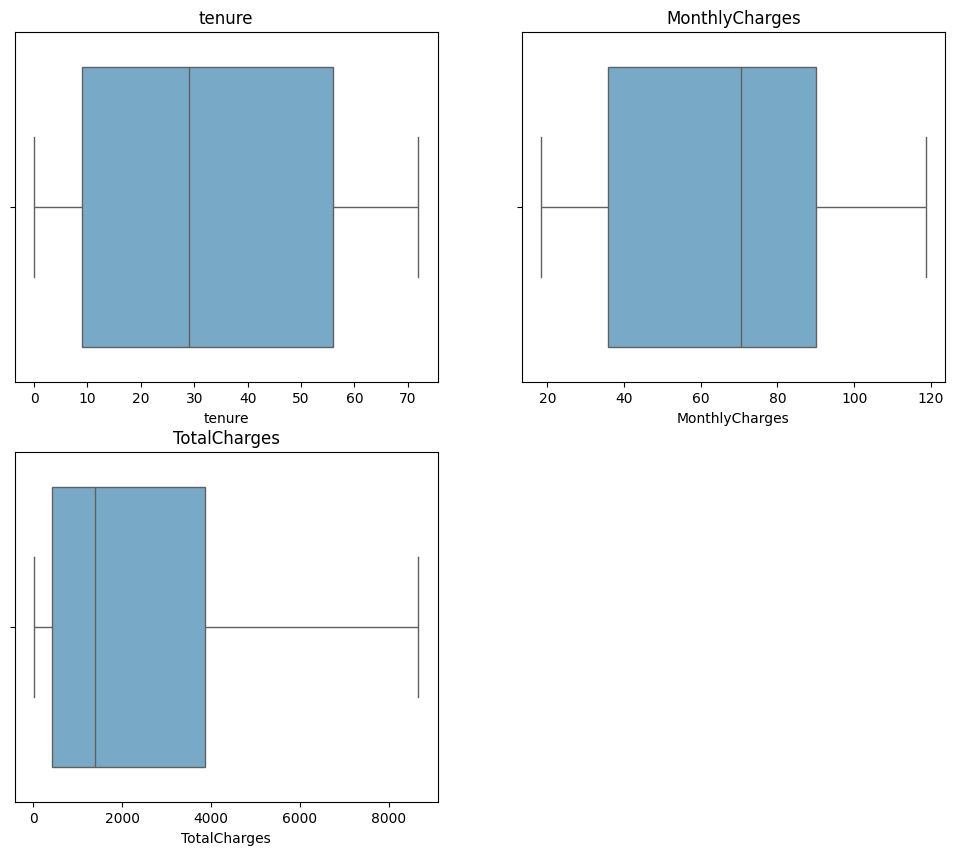

In [20]:
numerical_columns = ['tenure', 'MonthlyCharges', 'TotalCharges']
outlier_check_boxplot(combined_data,numerical_columns)

####    3.Univariate Analysis 

#####        a. Summary Statistics

In [21]:

summary_stats = combined_data.describe( include = 'all')
summary_stats

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
count,5043,5043,5043.000000,5043,5043,5043.000000,5043,4774,5043,4392,...,4392,4392,4392,4392,5043,5043,5043,5043.000000,5035.000000,5042
unique,5043,2,NaN,2,2,NaN,2,3,3,3,...,3,3,3,3,3,2,4,NaN,NaN,2
top,7590-VHVEG,Male,NaN,No,No,NaN,Yes,No,Fiber optic,No,...,No,No,No,Yes,Month-to-month,Yes,Electronic check,NaN,NaN,No
freq,1,2559,NaN,2585,3482,NaN,4554,2424,2248,2507,...,2219,2472,2018,1982,2744,2996,1700,NaN,NaN,3706
mean,NaN,NaN,0.162403,NaN,NaN,32.576641,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.090214,2302.062861,NaN
std,NaN,NaN,0.368857,NaN,NaN,24.529807,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.068133,2269.483576,NaN
min,NaN,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.400000,18.799999,NaN
25%,NaN,NaN,0.000000,NaN,NaN,9.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.775000,417.675003,NaN
50%,NaN,NaN,0.000000,NaN,NaN,29.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.550003,1401.150024,NaN
75%,NaN,NaN,0.000000,NaN,NaN,56.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,90.050003,3862.000000,NaN


#####        b. Distribution Visualization

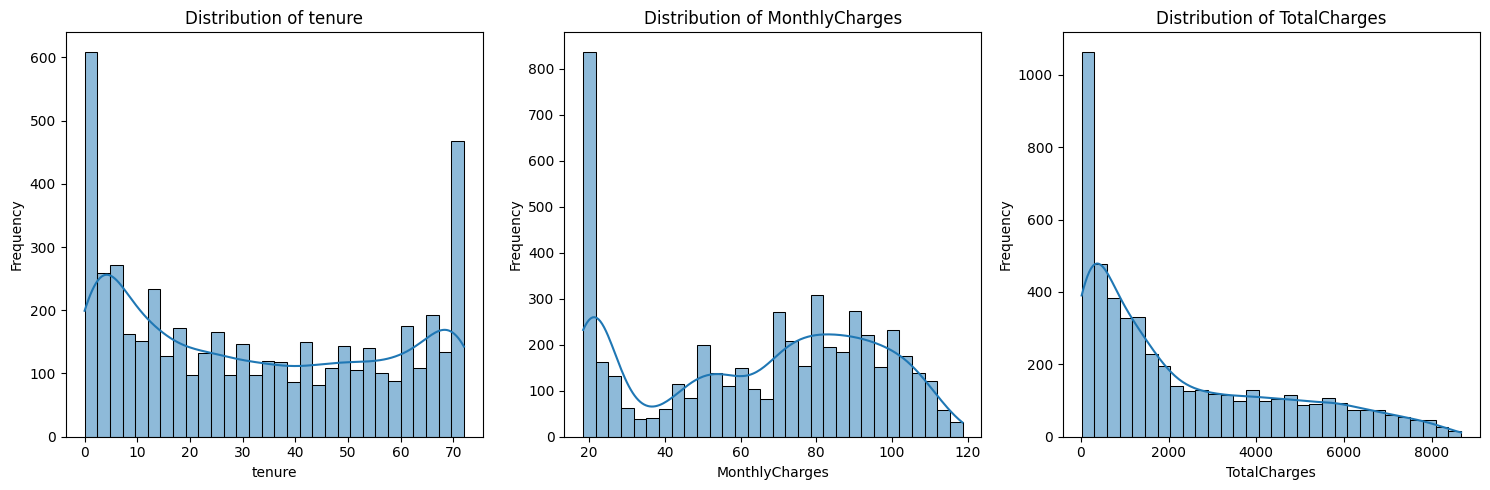

In [22]:
# Separate numerical columns

numerical_columns = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Set figure size for individual plots
plt.figure(figsize=(15, 5))

# Histogram for 'tenure'
plt.subplot(1, 3, 1)
sns.histplot(data=combined_data, x='tenure', kde=True, bins=30)
plt.title('Distribution of tenure')
plt.xlabel('tenure')
plt.ylabel('Frequency')

# Histogram for 'MonthlyCharges'
plt.subplot(1, 3, 2)
sns.histplot(data=combined_data, x='MonthlyCharges', kde=True, bins=30)
plt.title('Distribution of MonthlyCharges')
plt.xlabel('MonthlyCharges')
plt.ylabel('Frequency')

# Histogram for 'TotalCharges'
plt.subplot(1, 3, 3)
sns.histplot(data=combined_data, x='TotalCharges', kde=True, bins=30)
plt.title('Distribution of TotalCharges')
plt.xlabel('TotalCharges')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


 - None of the features above are normally distributed

####    4.Bivariate Analysis 

Customer Service Analysis 

In [23]:
#Make a function to plot categorical data according to target


def plot_categorical_to_target(df,categorical_values, target):
    number_of_columns = 2
    number_of_rows = math.ceil(len(categorical_values)/2)
    
    fig = plt.figure(figsize = (12, 5*number_of_rows))
    
    for index, column in enumerate(categorical_values, 1):
        ax = fig.add_subplot(number_of_rows,number_of_columns,index)
        ax = sns.countplot(x = column, data = combined_data, hue = target, palette="Blues_r")
        ax.set_title(column)
    return plt.show()

In [24]:
print(plt.colormaps()) 

['magma', 'inferno', 'plasma', 'viridis', 'cividis', 'twilight', 'twilight_shifted', 'turbo', 'Blues', 'BrBG', 'BuGn', 'BuPu', 'CMRmap', 'GnBu', 'Greens', 'Greys', 'OrRd', 'Oranges', 'PRGn', 'PiYG', 'PuBu', 'PuBuGn', 'PuOr', 'PuRd', 'Purples', 'RdBu', 'RdGy', 'RdPu', 'RdYlBu', 'RdYlGn', 'Reds', 'Spectral', 'Wistia', 'YlGn', 'YlGnBu', 'YlOrBr', 'YlOrRd', 'afmhot', 'autumn', 'binary', 'bone', 'brg', 'bwr', 'cool', 'coolwarm', 'copper', 'cubehelix', 'flag', 'gist_earth', 'gist_gray', 'gist_heat', 'gist_ncar', 'gist_rainbow', 'gist_stern', 'gist_yarg', 'gnuplot', 'gnuplot2', 'gray', 'hot', 'hsv', 'jet', 'nipy_spectral', 'ocean', 'pink', 'prism', 'rainbow', 'seismic', 'spring', 'summer', 'terrain', 'winter', 'Accent', 'Dark2', 'Paired', 'Pastel1', 'Pastel2', 'Set1', 'Set2', 'Set3', 'tab10', 'tab20', 'tab20b', 'tab20c', 'grey', 'gist_grey', 'gist_yerg', 'Grays', 'magma_r', 'inferno_r', 'plasma_r', 'viridis_r', 'cividis_r', 'twilight_r', 'twilight_shifted_r', 'turbo_r', 'Blues_r', 'BrBG_r', '

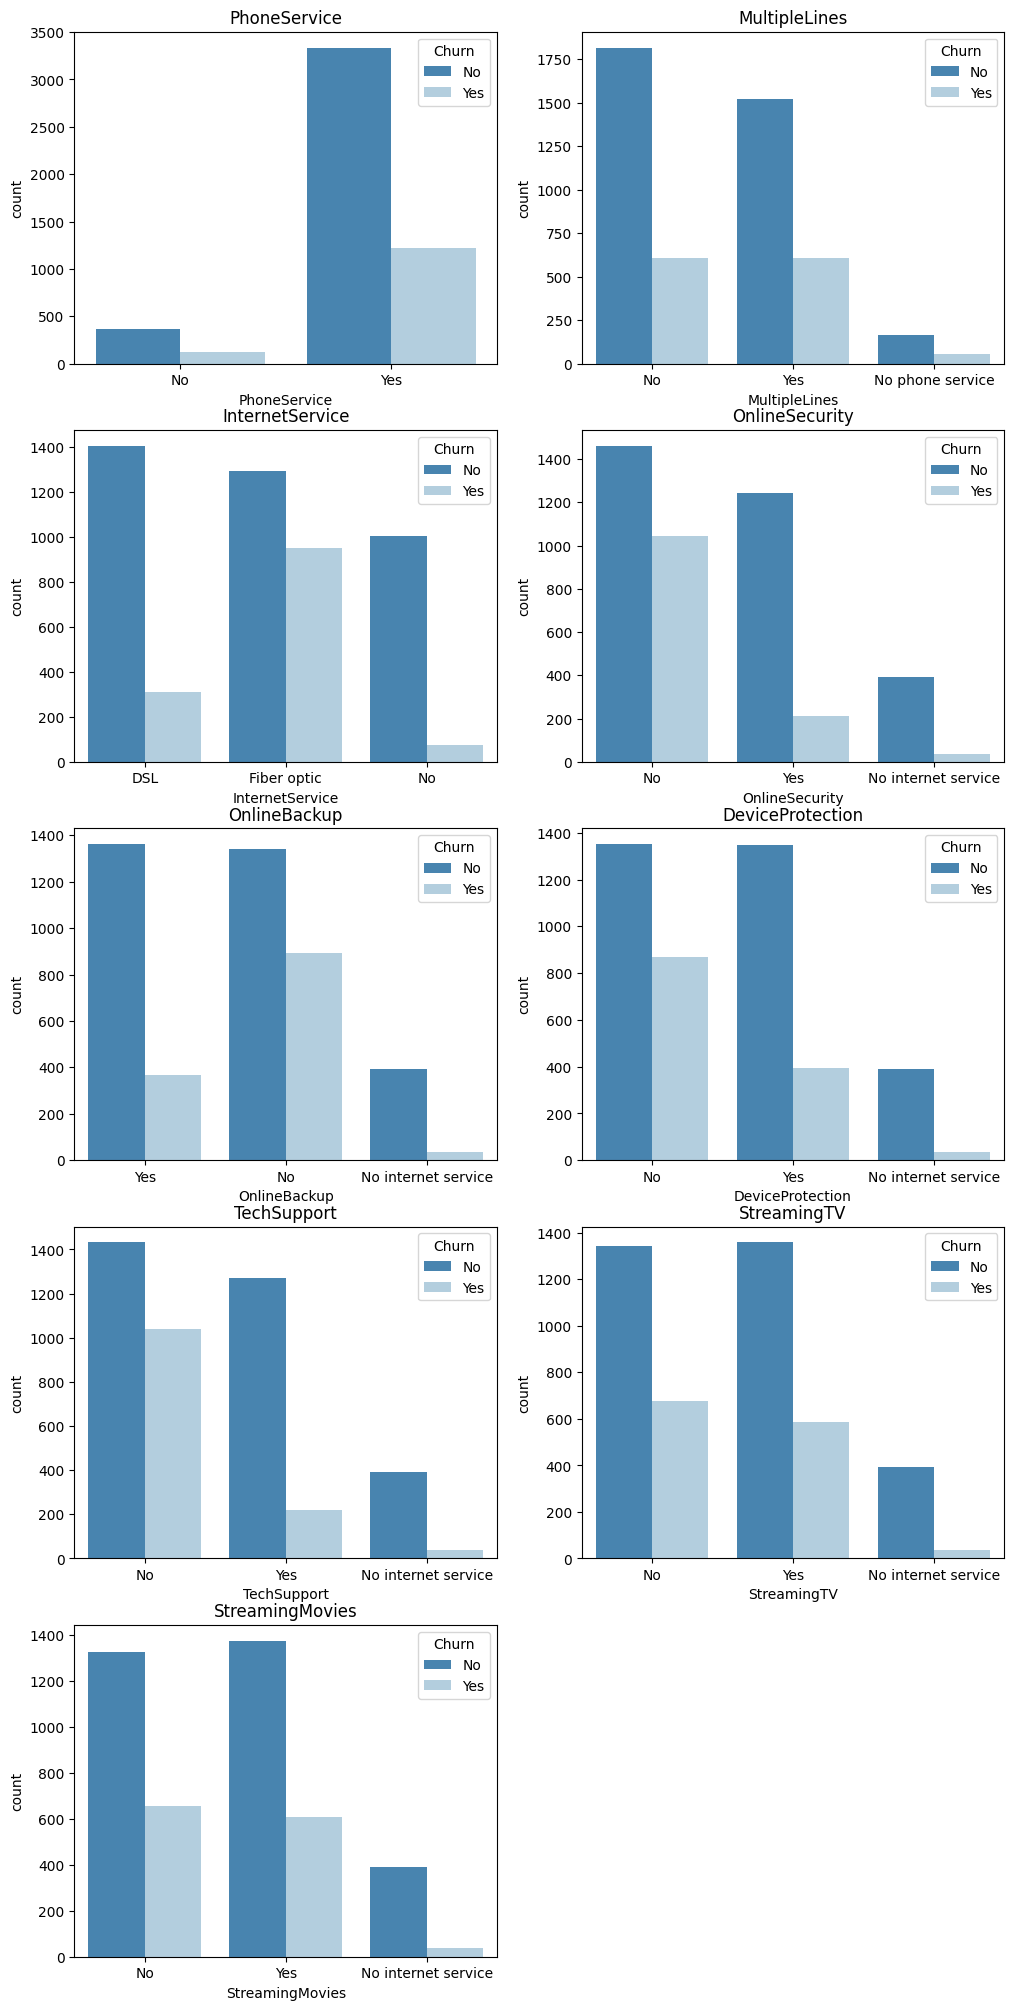

In [25]:
customer_services = ["PhoneService","MultipleLines","InternetService","OnlineSecurity","OnlineBackup",
                    "DeviceProtection","TechSupport","StreamingTV","StreamingMovies"]
plot_categorical_to_target(combined_data,customer_services, "Churn")


Customer Account Analysis - Categorical Variables

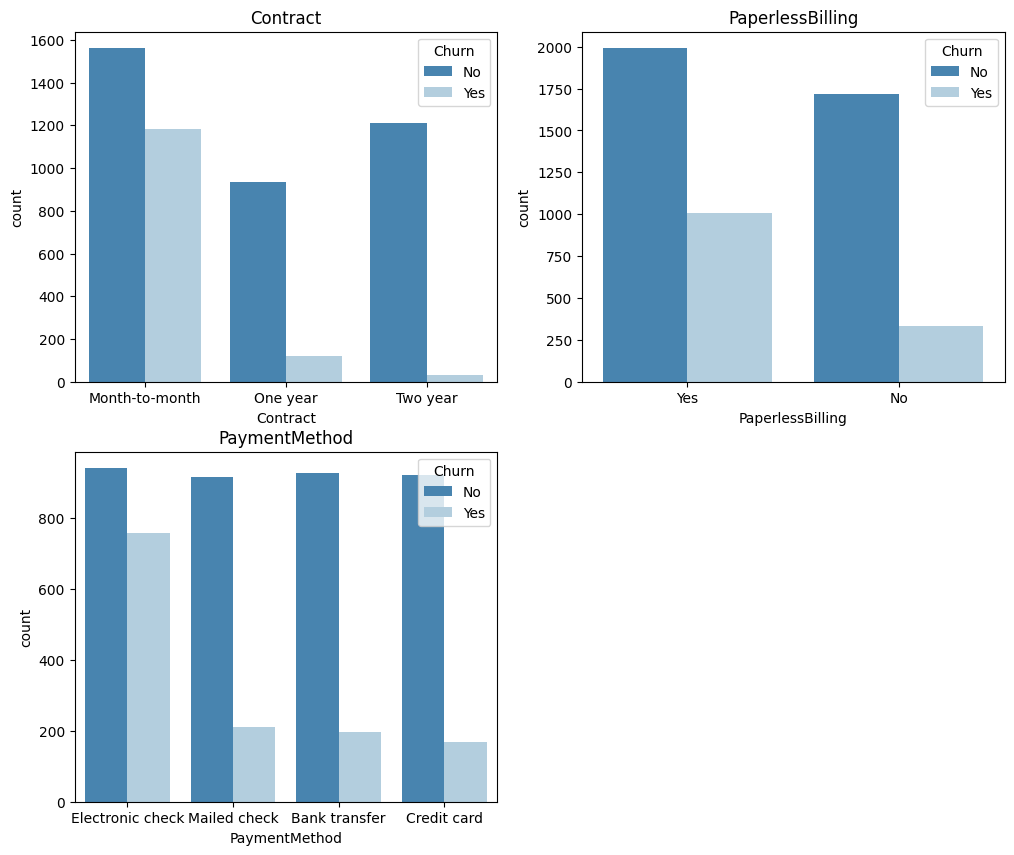

In [26]:
# Delete "automatic" from PaymentMethod for proper visualization

combined_data["PaymentMethod"] = combined_data["PaymentMethod"].str.replace(" (automatic)", "", regex=False)

customer_account_cat = ["Contract","PaperlessBilling","PaymentMethod"]
plot_categorical_to_target(combined_data,customer_account_cat,"Churn")

Customer Demographic Analysis - Categorical Variables

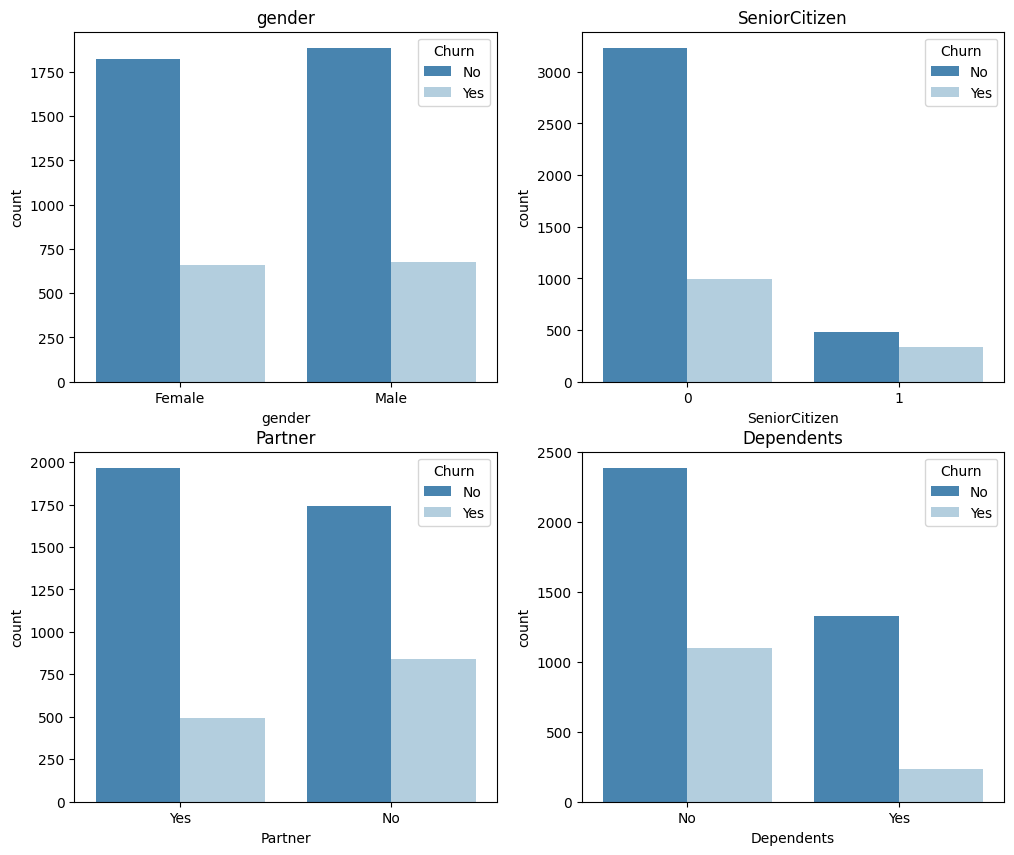

In [27]:
customer_demo_cat = ["gender","SeniorCitizen","Partner","Dependents"]
plot_categorical_to_target(combined_data,customer_demo_cat,"Churn")

####    5.Multivariate Analysis 


#####        a. Total Charges, Tenure and Churn

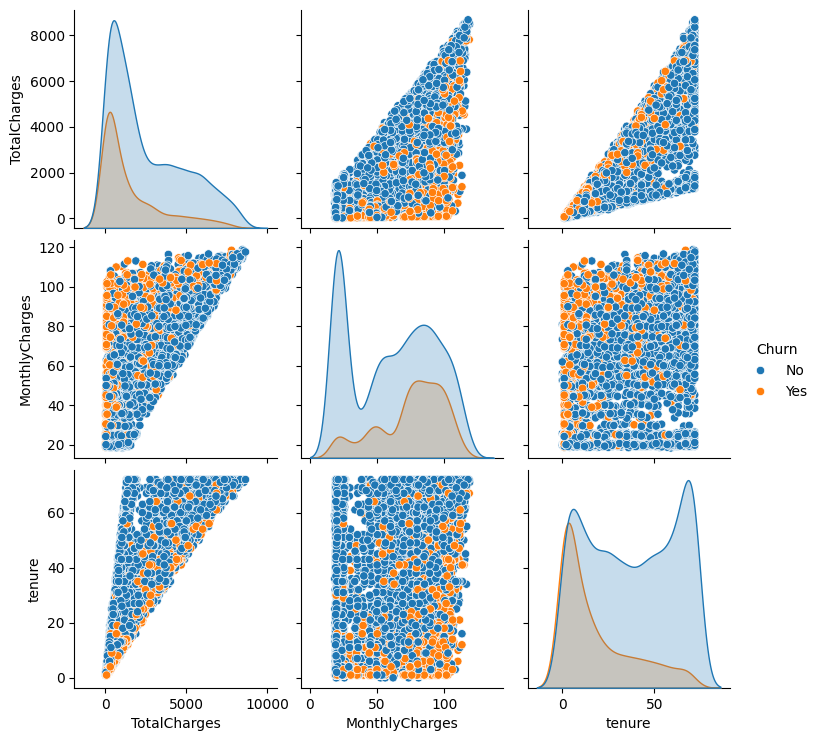

In [28]:
# Pair plot for TotalCharges, MonthlyCharges, Tenure, and Churn

sns.pairplot(combined_data[['TotalCharges', 'MonthlyCharges', 'tenure', 'Churn']], hue='Churn')
plt.show()


Interpretation:

The plots show pairwise relationships between TotalCharges, MonthlyCharges, and Tenure, colored by churn status.
There is a visible clustering of churned customers in certain areas, particularly those with high charges and low tenure.
High MonthlyCharges and low Tenure are indicative of cost-sensitive customers who are likely to churn.

Correlation Matrix Of Numeric Features

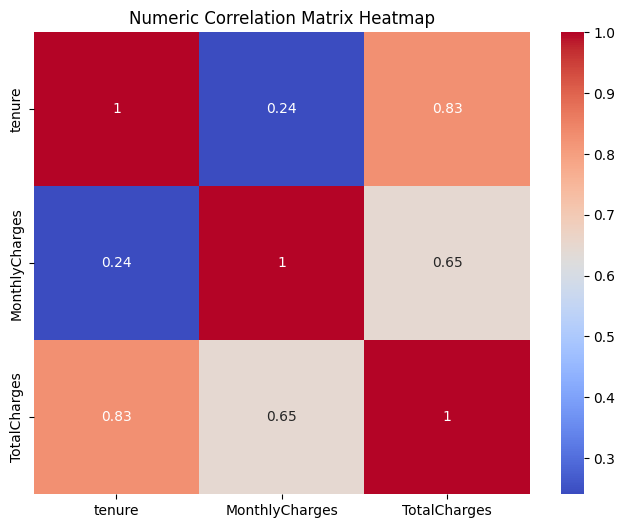

In [29]:
# Select only numeric columns for correlation matrix

numeric_columns = ['tenure', 'MonthlyCharges', 'TotalCharges']

plt.figure(figsize=(8, 6))
sns.heatmap(combined_data[numeric_columns].corr(), annot=True, cmap='coolwarm')
plt.title('Numeric Correlation Matrix Heatmap')
plt.show()

 - From the correlation matrix, there seems to be a strong relationship between tenure and total charges signifying that the longer the tenure the higher the total charges and vice versa 
 - There als seems to be a relative strong relationship between the monthly and total charges indicationg one highly contributes and impacts the other


#### Answering Analytical Questions


1. How do different customer demgraphics (Gender, SeniorCitizen, Partner, Dependents) influence churn?


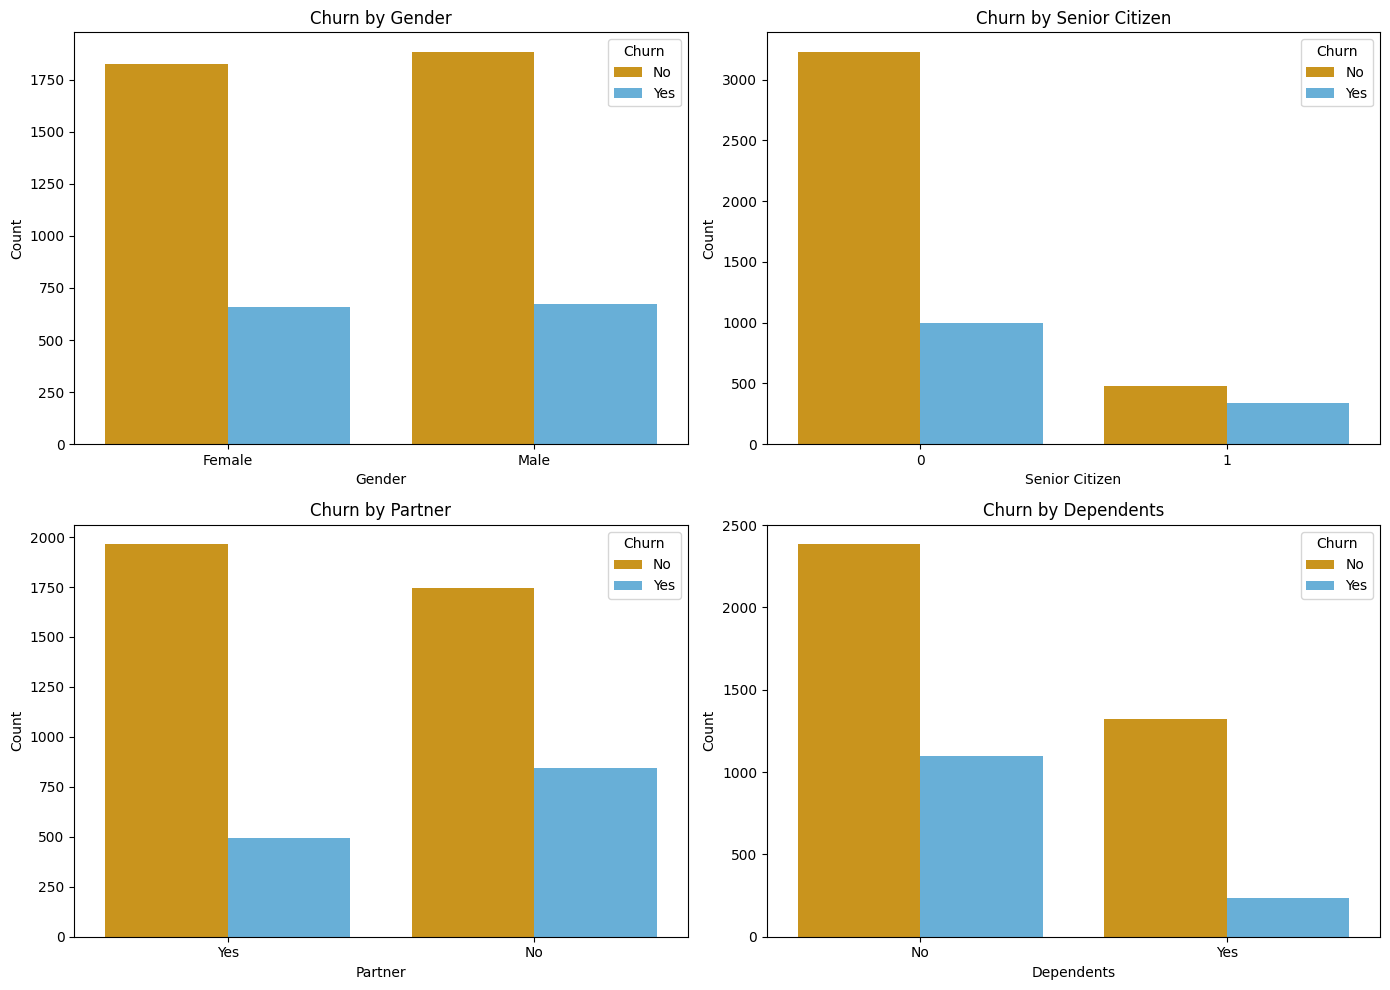

In [30]:
# Setting the color palette for better visualization
color_palette = ['#E69F00', '#56B4E9']

plt.figure(figsize=(14, 10))

# First plot: Churn by Gender
plt.subplot(2, 2, 1)  # 2 rows, 2 columns, 1st position
sns.countplot(x='gender', hue='Churn', data=combined_data, palette=color_palette)
plt.title('Churn by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')

# Second plot: Churn by Senior Citizen
plt.subplot(2, 2, 2)  # 2nd position
sns.countplot(x='SeniorCitizen', hue='Churn', data=combined_data, palette=color_palette)
plt.title('Churn by Senior Citizen')
plt.xlabel('Senior Citizen')
plt.ylabel('Count')

# Third plot: Churn by Partner
plt.subplot(2, 2, 3)  # 3rd position
sns.countplot(x='Partner', hue='Churn', data=combined_data, palette=color_palette)
plt.title('Churn by Partner')
plt.xlabel('Partner')
plt.ylabel('Count')

# Fourth plot: Churn by Dependents
plt.subplot(2, 2, 4)  # 4th position
sns.countplot(x='Dependents', hue='Churn', data=combined_data, palette=color_palette)
plt.title('Churn by Dependents')
plt.xlabel('Dependents')
plt.ylabel('Count')

# Make sure everything fits nicely
plt.tight_layout()

plt.show()

-Senior citizen dockets seems to have a significantly highy difference showing that young citizens remore likely to churn as compared to senior citizens
- When it comes to partners, those with patners are less likely to churn unlike those that are without patners
- With dependants, those without dependants have a higher churn count vis a vis those with dependants 
- Gender doesn't have to have much significnce as the difference is minimal between the male and female gender

2. Which services (PhoneService, MultipleLines, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies) are associated with higher churn rates?

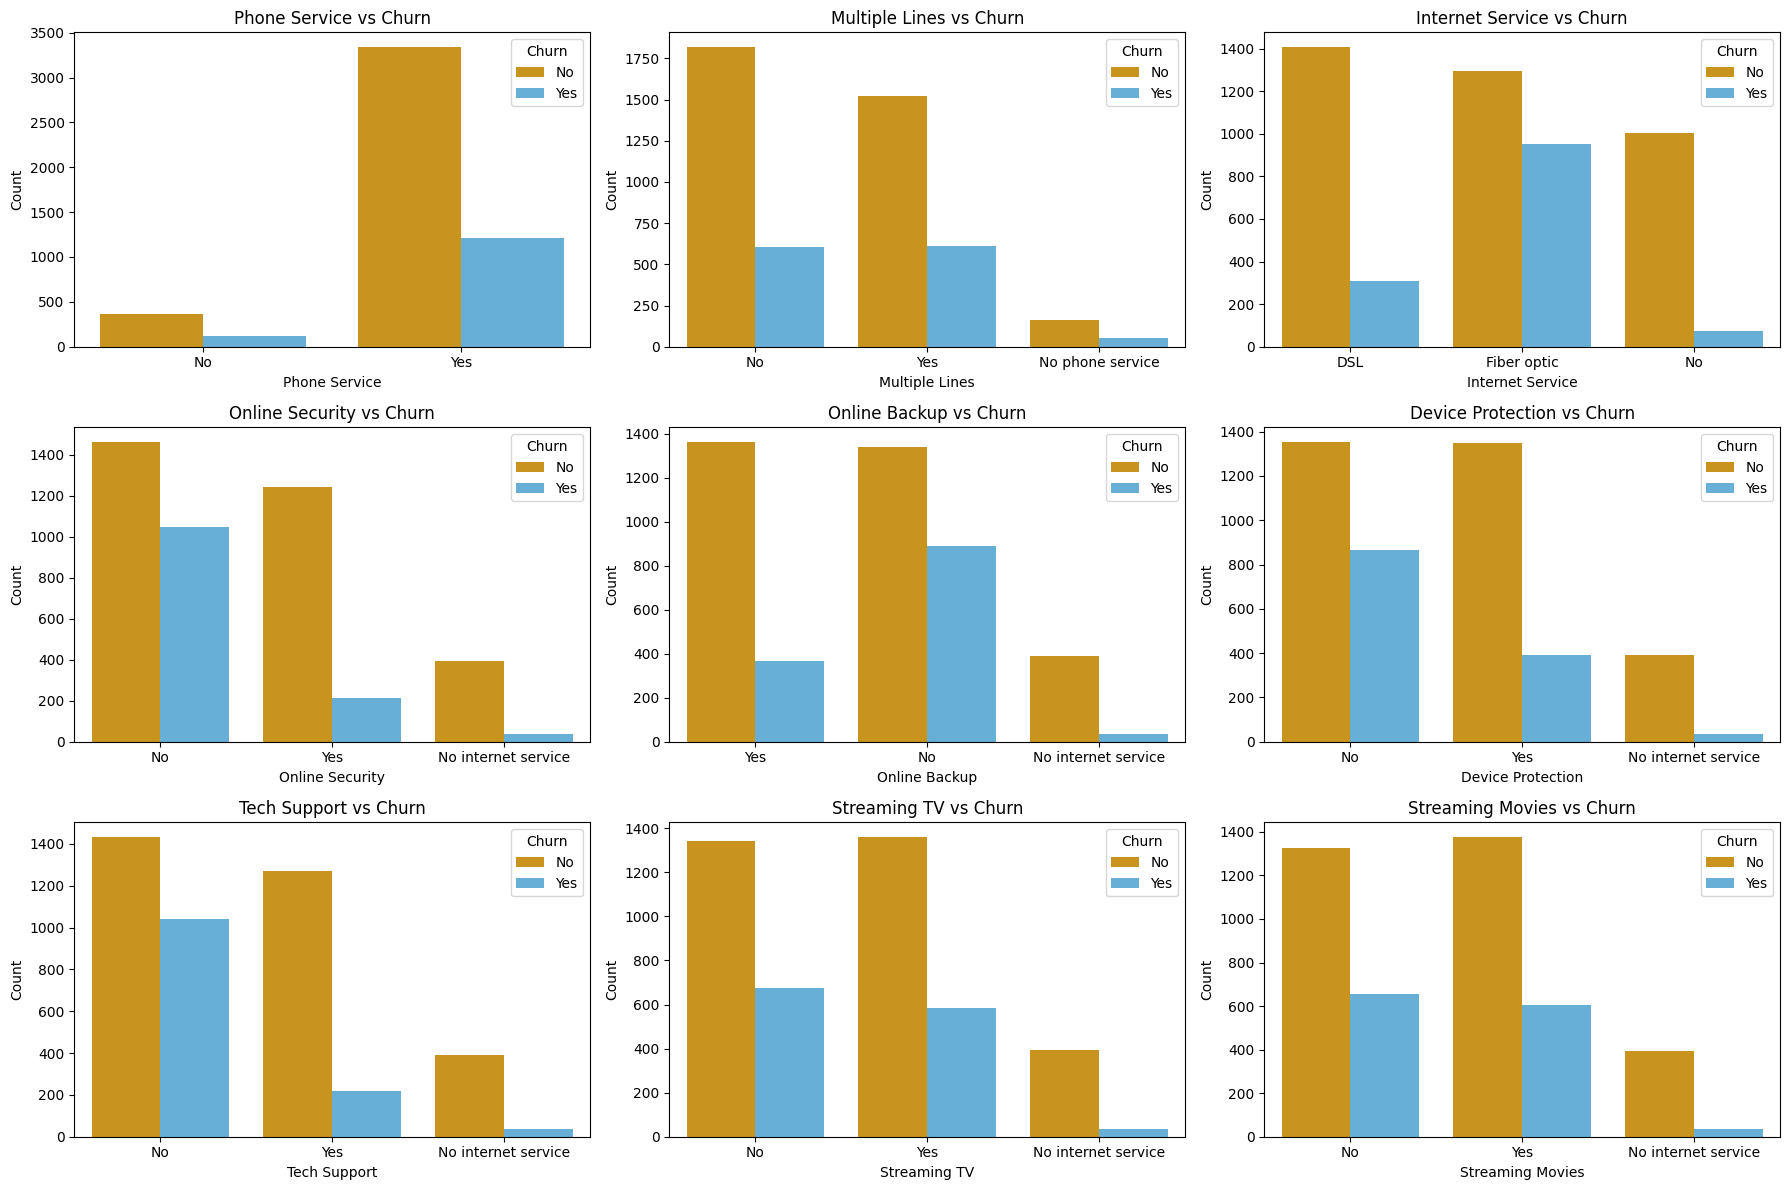

In [31]:

# Set a colorblind-friendly palette
color_palette = ['#E69F00', '#56B4E9']

# Create a big canvas to hold all the small plots
plt.figure(figsize=(18, 12))

# First plot: Phone Service
plt.subplot(3, 3, 1)  # 3 rows, 3 columns, 1st position
sns.countplot(data=combined_data, x='PhoneService', hue='Churn', palette=color_palette)
plt.title('Phone Service vs Churn')
plt.xlabel('Phone Service')
plt.ylabel('Count')

# Second plot: Multiple Lines
plt.subplot(3, 3, 2)  # 2nd position
sns.countplot(data=combined_data, x='MultipleLines', hue='Churn', palette=color_palette)
plt.title('Multiple Lines vs Churn')
plt.xlabel('Multiple Lines')
plt.ylabel('Count')

# Third plot: Internet Service
plt.subplot(3, 3, 3)  # 3rd position
sns.countplot(data=combined_data, x='InternetService', hue='Churn', palette=color_palette)
plt.title('Internet Service vs Churn')
plt.xlabel('Internet Service')
plt.ylabel('Count')

# Fourth plot: Online Security
plt.subplot(3, 3, 4)  # 4th position
sns.countplot(data=combined_data, x='OnlineSecurity', hue='Churn', palette=color_palette)
plt.title('Online Security vs Churn')
plt.xlabel('Online Security')
plt.ylabel('Count')

# Fifth plot: Online Backup
plt.subplot(3, 3, 5)  # 5th position
sns.countplot(data=combined_data, x='OnlineBackup', hue='Churn', palette=color_palette)
plt.title('Online Backup vs Churn')
plt.xlabel('Online Backup')
plt.ylabel('Count')

# Sixth plot: Device Protection
plt.subplot(3, 3, 6)  # 6th position
sns.countplot(data=combined_data, x='DeviceProtection', hue='Churn', palette=color_palette)
plt.title('Device Protection vs Churn')
plt.xlabel('Device Protection')
plt.ylabel('Count')

# Seventh plot: Tech Support
plt.subplot(3, 3, 7)  # 7th position
sns.countplot(data=combined_data, x='TechSupport', hue='Churn', palette=color_palette)
plt.title('Tech Support vs Churn')
plt.xlabel('Tech Support')
plt.ylabel('Count')

# Eighth plot: Streaming TV
plt.subplot(3, 3, 8)  # 8th position
sns.countplot(data=combined_data, x='StreamingTV', hue='Churn', palette=color_palette)
plt.title('Streaming TV vs Churn')
plt.xlabel('Streaming TV')
plt.ylabel('Count')

# Ninth plot: Streaming Movies
plt.subplot(3, 3, 9)  # 9th position
sns.countplot(data=combined_data, x='StreamingMovies', hue='Churn', palette=color_palette)
plt.title('Streaming Movies vs Churn')
plt.xlabel('Streaming Movies')
plt.ylabel('Count')

# Make sure everything fits nicely
plt.tight_layout()

plt.show()


- Customers with no internet service are less likely to churn, indicating that internet service type is a significant factor
- Lack of online security correlates positively with churn, suggesting that customers without this service might be more prone to leaving
- MultipleLines could be related to whether the customer has a phone service plan or the type of phone service they have
- This links directly to why those with phone service are likely to churn
- Both steaming services, that is, Tv and Movies, seemto have moderately the same impact when it comes to churn  and unchurn count

3. Can payment methods affect customer retention?

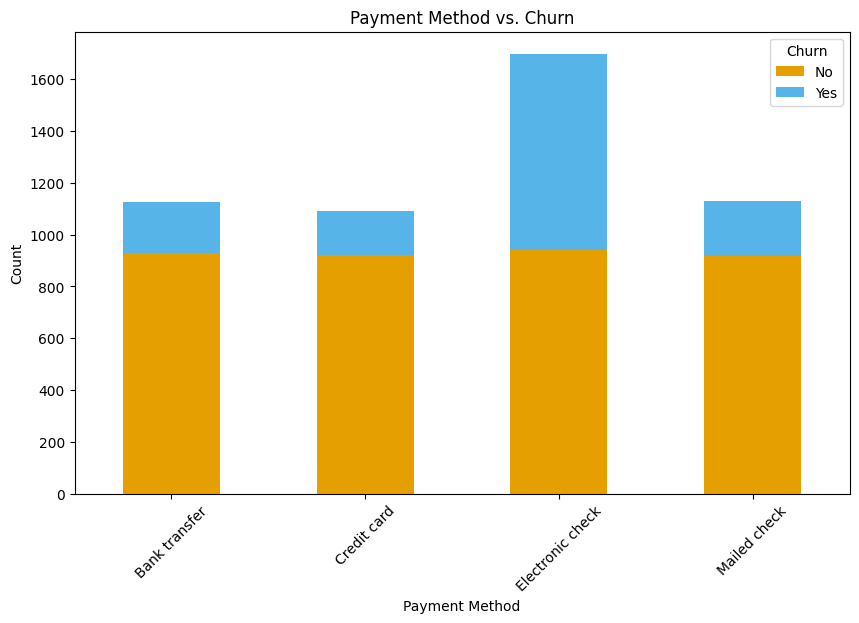

In [32]:
# Stacked bar plot

color_palette = ['#E69F00', '#56B4E9']

# Create a stacked bar plot for Payment Method vs. Churn

payment_churn = combined_data.groupby(['PaymentMethod', 'Churn']).size().unstack()
payment_churn.plot(kind='bar', stacked=True, figsize=(10, 6), color=color_palette)

# Customize the plot
plt.title('Payment Method vs. Churn')
plt.xlabel('Payment Method')
plt.ylabel('Count')
plt.grid(False)
plt.legend(title='Churn')
plt.xticks(rotation=45)
plt.show()



- Payment method does seem to have an impact on churn with electronic check having the highest churn count in comparison with the rest of the payment methods meaning those that use the electronic check payment method are more likely to churn

4. Is there a correlation between tenure and churn ?

In [33]:
# Check for maximum tenure 
combined_data['tenure'].max()

72

In [34]:
# Function to create year ranges (in months)

def to_years(x):
    if x <= 12:
        return '0-1 year'
    elif x > 12 and x <= 24:
        return '1-2 years'
    elif x > 24 and x <= 36:
        return '2-3 years'
    elif x > 36 and x <= 48:
        return '3-4 years'
    elif x > 48 and x <= 60:
        return '4-5 years'
    elif x > 60 and x <= 72:
        return '5-6 years'
    elif x > 72:
        return '6 + years'

In [35]:
# Create column for tenure groups

combined_data['tenure_group'] = combined_data['tenure'].apply(to_years)

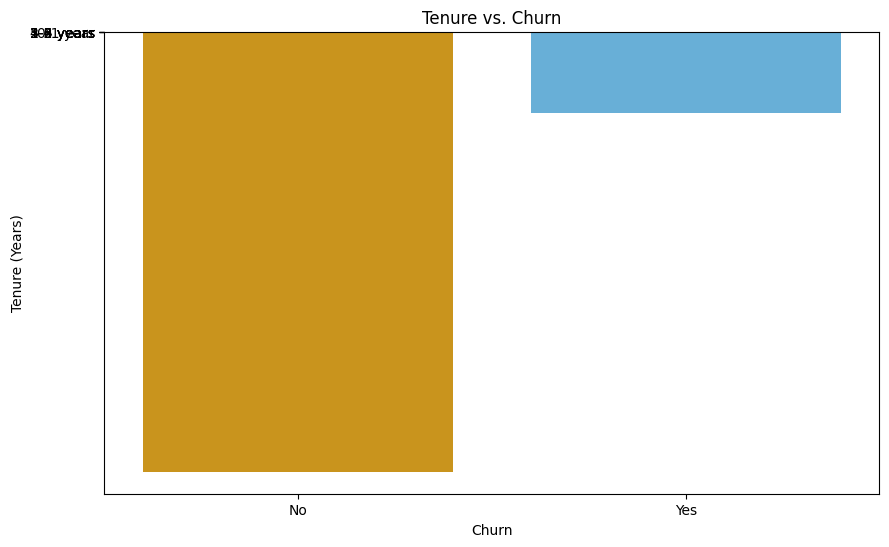

"\ncolor_palette = ['#E69F00', '#56B4E9']\n\nplt.figure(figsize=(10, 6))\nsns.barplot(x='Churn',y='tenure_group', data=combined_data, ci=None, estimator=sum, palette=color_palette)\nplt.title('Tenure vs. Churn')\nplt.xlabel('Churn')\nplt.ylabel('Total Tenure (Years)')\nplt.grid(False)\nplt.show()\n"

In [36]:
# Tenure vs Churn

color_palette = ['#E69F00', '#56B4E9']

plt.figure(figsize=(10, 6))
sns.barplot(x='Churn', y='tenure_group', data=combined_data, ci=None, estimator=sum, palette=color_palette)
plt.title('Tenure vs. Churn')
plt.xlabel('Churn')
plt.ylabel('Tenure (Years)')
plt.grid(False)
plt.show()


'''
color_palette = ['#E69F00', '#56B4E9']

plt.figure(figsize=(10, 6))
sns.barplot(x='Churn',y='tenure_group', data=combined_data, ci=None, estimator=sum, palette=color_palette)
plt.title('Tenure vs. Churn')
plt.xlabel('Churn')
plt.ylabel('Total Tenure (Years)')
plt.grid(False)
plt.show()
'''

- As tenure length increases, churn rate decreases suggesing that customers with longer tenures are less likely to leave as compared to customers with less tenures, that is, the relatively new customers

5. Does the type of contract influence customer churn?

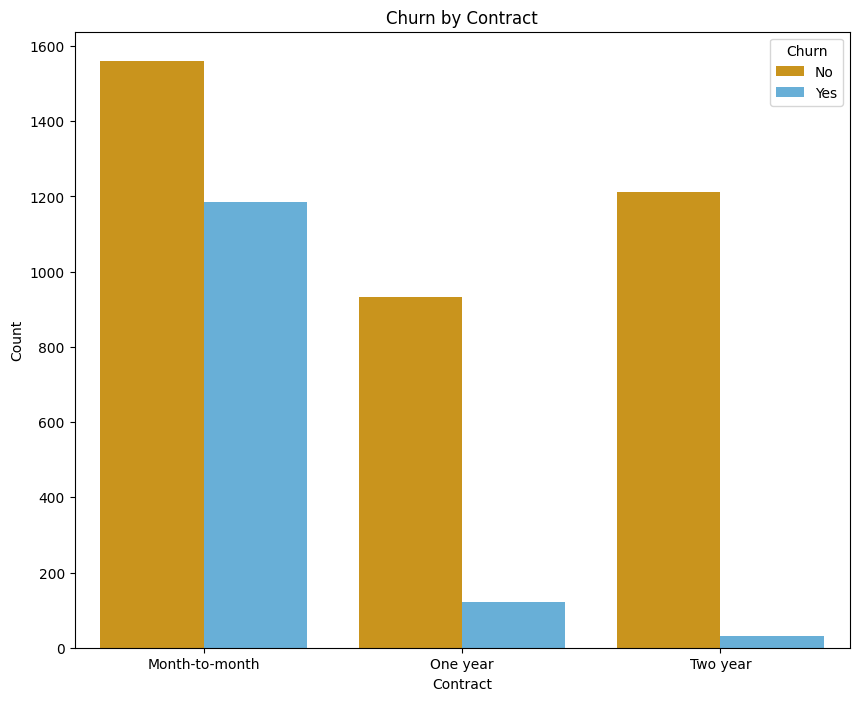

In [37]:

color_palette = ['#E69F00', '#56B4E9']

plt.figure(figsize=(10, 8))
sns.countplot(x='Contract', hue='Churn', data=combined_data, palette=color_palette)
plt.title('Churn by Contract')
plt.xlabel('Contract')
plt.ylabel('Count')
plt.show()

Similar to tenure, as contract length increases, churn rate decreases indicating that short term contract customers have an extremely high likelihood of churning compared to long term contact customers


####        Hypothesis

Test Hypothesis

For hypothesis testing, we'll look at a couple of attributes to determine if we should reject our hypothesis or fail to reject it.

In [38]:
# Checking data types
print(combined_data.dtypes)

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
tenure_group         object
dtype: object


In [39]:

from scipy.stats import chi2_contingency

# Create a contingency table

contingency_table = pd.crosstab(combined_data['PaymentMethod'], combined_data['Churn'])
print("Contingency Table:")
print(contingency_table)

# Perform the chi-square test for independence
chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-Square Statistic: {chi2_stat}")
print(f"P-value: {p_val}")

# Interpret the result
alpha = 0.05
if p_val < alpha:
    print("Reject the null hypothesis: There is a significant association between paymment method and churn ")
else:
    print("Fail to reject the null hypothesis: There is no significant association between payment method and churn ")

Contingency Table:
Churn              No  Yes
PaymentMethod             
Bank transfer     927  198
Credit card       922  168
Electronic check  941  758
Mailed check      916  212
Chi-Square Statistic: 435.18429892111146
P-value: 5.286903609382345e-94
Reject the null hypothesis: There is a significant association between paymment method and churn 


Contract Interpretation:
The low p-value suggests a strong relationship between the type of contract and churn. Customers on different contract terms (month-to-month, one year, two years) have significantly different churn rates. Month-to-month contracts, for example, might be more likely to churn compared to longer-term contracts.

Gender Interpretation:
The high p-value indicates that gender does not significantly affect churn rates. In other words, male and female customers churn at similar rates, and gender is not a significant predictor of whether a customer will churn.

Tenure Interpretation:
The very low p-value suggests a strong relationship between tenure and churn. Customers with different tenures have significantly different churn rates. Typically, customers with shorter tenures are more likely to churn compared to those who have been with the company for a longer period.

Total Charges Interpretation:
The p-value is greater than 0.05, suggesting that there is no significant relationship between total charges and churn.Therefore, total charges do not significantly influence churn rates.

Payment Method Interpretation:
The p-value is very small, indicating a highly significant relationship between payment method and churn. Different payment methods have significantly different churn rates.


Null Hypothesis (H0): 
There is no significant relationship between customer attributes (demographics, usage patterns, etc.) and churn.
    Alternative Hypothesis (H1): 
Specific customer attributes significantly influence churn rates.

With the p levels of different attributes, we thereby reject the null hypothesist that There is no significant relationship between customer attributes and churn rate

At a significance level of 5%, there is enough evidence to conclude that different attributes such as demographs, contract types, payment methods etc do affect the churn rates


## Data Preparation

###    a. Separating The Data

#### Overview Of Columns

In [40]:
combined_data.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn',
       'tenure_group'],
      dtype='object')

In [41]:
combined_data.nunique()

customerID          5043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      2069
TotalCharges        4863
Churn                  2
tenure_group           6
dtype: int64

#### Drop Irrelevant Columns

In [42]:
combined_data.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn',
       'tenure_group'],
      dtype='object')

In [43]:

combined_data.drop(columns=['customerID'], inplace=True)
# Customer ID and tenure group will be irrelevant when it comes to modelling

In [44]:
combined_data.drop(columns=['tenure_group'], inplace=True)

In [45]:
combined_data.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [46]:
combined_data['Churn'].value_counts()

Churn
No     3706
Yes    1336
Name: count, dtype: int64

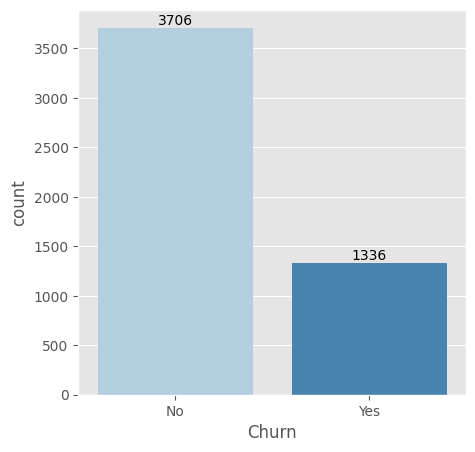

In [47]:
#Apply the ggplot style

plt.style.use("ggplot")

plt.figure(figsize=(5,5))
ax = sns.countplot(x = combined_data["Churn"],palette="Blues")
for container in ax.containers:
    ax.bar_label(container)
plt.show()


This is an unbalanced data since the churned count is roughly more than twice of the unchurned

####    Separate features (X) and target variable (y)

In [48]:
X = combined_data.drop(['Churn'], axis=1)
y = combined_data['Churn']

In [49]:
X.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges'],
      dtype='object')

In [50]:
y.unique()

array(['No', 'Yes', nan], dtype=object)

In [51]:
y.value_counts()

Churn
No     3706
Yes    1336
Name: count, dtype: int64

####    Split Dataset into Categorical and Numerical Columns

In [52]:
# Numerical

numeric_features = X.select_dtypes('number').columns
numeric_features

Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')

In [53]:
# Categorical

categorical_features = X.select_dtypes('object').columns
categorical_features

Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object')

###    Feature Engineering

####        Handling Missing Values

In [54]:
combined_data.isna().sum()

gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines       269
InternetService       0
OnlineSecurity      651
OnlineBackup        651
DeviceProtection    651
TechSupport         651
StreamingTV         651
StreamingMovies     651
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          8
Churn                 1
dtype: int64

In [55]:
# 1. Handling missing values for service-related features -01

# Check if customer has no internet service and fill related columns with 'No'

service_columns = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                   'TechSupport', 'StreamingTV', 'StreamingMovies']

# Fill 'No' where InternetService is 'No'

for col in service_columns:
    combined_data.loc[combined_data['InternetService'] == 'No', col] = 'No'

# If PhoneService is 'No', MultipleLines should be 'No'

combined_data.loc[combined_data['PhoneService'] == 'No', 'MultipleLines'] = 'No'


In [57]:
# 2. Handling missing TotalCharges

# Fill missing TotalCharges with 0 where tenure is 0

combined_data['TotalCharges'] = pd.to_numeric(combined_data['TotalCharges'], errors='coerce')

combined_data.loc[combined_data['tenure'] == 0, 'TotalCharges'] = 0

# Fill any remaining missing TotalCharges with median value

combined_data['TotalCharges'].fillna(combined_data['TotalCharges'].median(), inplace=True)


In [58]:
# 3. Handling missing Churn

# Fill missing Churn with the most frequent value

combined_data['Churn'].fillna(combined_data['Churn'].mode()[0], inplace=True)


In [59]:
combined_data.isna().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [60]:
# Display all rows with any NaN values
print(combined_data[combined_data.isnull().any(axis=1)])


Empty DataFrame
Columns: [gender, SeniorCitizen, Partner, Dependents, tenure, PhoneService, MultipleLines, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, Contract, PaperlessBilling, PaymentMethod, MonthlyCharges, TotalCharges, Churn]
Index: []


Service Features
 For each column related to services, check if InternetService is 'No' and fill in the respective service columns with 'No'. Similarly, if PhoneService is 'No', we set MultipleLines to 'No'.

TotalCharges
 Convert TotalCharges to numeric to handle any non-numeric values. For customers with tenure equal to 0, we assume they have not been charged yet and set TotalCharges to 0. Fill any remaining missing values with the median of TotalCharges.

Churn
 We fill the missing Churn value with the mode (most frequent value). This is usually either 'Yes' or 'No'.

####    Split Dataset into Training and Evaluation

In [61]:
print(combined_data[combined_data.isnull().any(axis=1)])

Empty DataFrame
Columns: [gender, SeniorCitizen, Partner, Dependents, tenure, PhoneService, MultipleLines, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, Contract, PaperlessBilling, PaymentMethod, MonthlyCharges, TotalCharges, Churn]
Index: []


In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 42)

In [61]:
print(X.shape, X_train.shape, X_test.shape)

(5043, 19) (3782, 19) (1261, 19)


####        Handling missing values using simple imputer

In [63]:
# Verify missing values using simple imputer

# Create imputers

numeric_imputer = SimpleImputer(strategy='median')  
categorical_imputer = SimpleImputer(strategy='most_frequent')

# Impute missing values for numerical features
combined_data[numeric_features] = numeric_imputer.fit_transform(combined_data[numeric_features])

# Impute missing values for categorical features
combined_data[categorical_features] = categorical_imputer.fit_transform(combined_data[categorical_features])


####        Scale or normalize numeric features

In [64]:
# Check for skewness to determine the scaler to use

X.select_dtypes('number').skew()

SeniorCitizen     1.831228
tenure            0.225132
MonthlyCharges   -0.238767
TotalCharges      0.944097
dtype: float64

In [65]:

# Create the scaler for numerical features

scaler = RobustScaler()

# Fit and transform numerical features

X_numeric = combined_data[numeric_features]
X_numeric_scaled = scaler.fit_transform(X_numeric)

# Convert the scaled data back to a DataFrame for easier handling

X_numeric_scaled_df = pd.DataFrame(X_numeric_scaled, columns=numeric_features)

X_numeric_scaled_df.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
0,0.0,-0.595745,-0.749885,-0.397679
1,0.0,0.106383,-0.250576,0.142627
2,0.0,-0.574468,-0.307692,-0.374929
3,0.0,0.340426,-0.520498,0.128463
4,0.0,-0.574468,0.002764,-0.362291


####        Perform transformations for skewed data

In [66]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,5043.0,0.162403,0.368857,0.000000,0.000000,0.000000,0.000000,1.000000
tenure,5043.0,32.576641,24.529807,0.000000,9.000000,29.000000,56.000000,72.000000
MonthlyCharges,5043.0,65.090214,30.068133,18.400000,35.775000,70.550003,90.050003,118.650002
TotalCharges,5035.0,2302.062861,2269.483576,18.799999,417.675003,1401.150024,3862.000000,8670.100000


####        Encode input features

In [67]:
# Check for NaNs in categorical features

nan_counts = combined_data[categorical_features].isna().sum()
nan_counts


gender              0
Partner             0
Dependents          0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
dtype: int64

In [68]:

# Create the encoder for categorical features

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fit and transform categorical features

X_categorical = combined_data[categorical_features]
X_categorical_encoded = encoder.fit_transform(X_categorical)

# Convert the encoded data back to a DataFrame
# Column names are generated by combining feature name and category
encoded_feature_names = encoder.get_feature_names_out(categorical_features)
X_categorical_encoded_df = pd.DataFrame(X_categorical_encoded, columns=encoded_feature_names)

X_categorical_encoded_df.head()


,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_Yes,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer,PaymentMethod_Credit card,PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


####        Encode output features

In [69]:
encoder = LabelEncoder()

y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)

###        Combining everything into a pipeline

In [70]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Create a pipeline for numeric features

numeric_pipeline = Pipeline(steps=[
    ('num_imputer', SimpleImputer(strategy='median')),  # Impute missing values with median
    ('scaler', RobustScaler()),
    ('power-transformation', PowerTransformer (method='yeo-johnson'))
])

# Create a pipeline for categorical features

categorical_pipeline = Pipeline(steps=[
    ('cat_imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing values with most frequent value
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore')
)
])

# Combine the two pipelines

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, numeric_features),
        ('cat', categorical_pipeline, categorical_features)
    ])

'''
# Fit and transform the data

X_processed = preprocessor.fit_transform(combined_data)

# Convert processed data to DataFrame for inspection

processed_feature_names = numeric_features + list(encoder.get_feature_names_out(categorical_features))
X_processed_df = pd.DataFrame(X_processed, columns=processed_feature_names)

print(X_processed_df.head())
'''

'\n# Fit and transform the data\n\nX_processed = preprocessor.fit_transform(combined_data)\n\n# Convert processed data to DataFrame for inspection\n\nprocessed_feature_names = numeric_features + list(encoder.get_feature_names_out(categorical_features))\nX_processed_df = pd.DataFrame(X_processed, columns=processed_feature_names)\n\nprint(X_processed_df.head())\n'

In [70]:
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('num_imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', RobustScaler()),
                                                 ('power-transformation',
                                                  PowerTransformer())]),
                                 Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('cat_imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object'))])


## 4. Modeling

####    a. Fit Data to the Pipeline and Train Model
    
Train multiple models:Logistic Regression, Decision Tree Classifier, Random Forest, Support Vector Machine

In [71]:

# from sklearn.metrics import classification_report

# Initialize models

models = [
    ('Decision Tree', DecisionTreeClassifier(random_state=42)),
    ('SVC', SVC(random_state=42, probability=True)),
    ('Random Forest', RandomForestClassifier(random_state=42)),
    ('Logistics Regression', LogisticRegression(random_state=42))
]

In [72]:
for model_name, classifier in models:
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])
    pipeline.fit(X_train, y_train_encoded)
    y_pred = pipeline.predict(X_test)

    print(f'Model: {model_name}')
    print(classification_report(y_test_encoded, y_pred))
    print('=' * 50)

Model: Decision Tree
              precision    recall  f1-score   support

           0       0.82      0.79      0.80       927
           1       0.47      0.53      0.50       334

    accuracy                           0.72      1261
   macro avg       0.65      0.66      0.65      1261
weighted avg       0.73      0.72      0.72      1261

Model: SVC
              precision    recall  f1-score   support

           0       0.84      0.90      0.87       927
           1       0.64      0.51      0.57       334

    accuracy                           0.79      1261
   macro avg       0.74      0.70      0.72      1261
weighted avg       0.78      0.79      0.79      1261

Model: Random Forest
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       927
           1       0.62      0.54      0.58       334

    accuracy                           0.79      1261
   macro avg       0.73      0.71      0.72      1261
weighted avg       0.

Decision Tree
    -The precision and recall for class 1 (churn) are relatively low, indicating that the Decision Tree model struggles with identifying churn cases.
    -The model has a higher performance for class 0 (non-churn), with better precision, recall, and F1-score.
    -The overall accuracy is 72%

Support Vector Machine (SVC)
    -SVC performs better than the Decision Tree, with an accuracy of 79%.
    -It shows a good balance between precision and recall for class 1 (churn), though recall is slightly lower.
    -The F1-score for class 1 is higher than that of the Decision Tree, indicating better overall performance in identifying churn.

Random Forest
    -Random Forest has a comparable accuracy to SVC (79%).
    -The F1-score for class 1 (churn) is similar to that of SVC, indicating decent performance in identifying churn cases.
    -Random Forest's precision for class 1 is slightly lower than that of SVC, but recall is similar.

Logistic Regression
    -Logistic Regression also achieves an accuracy of 79%, similar to SVC and Random Forest.
    -The precision and recall for class 1 are comparable to those of Random Forest and SVC.

## Evaluation

####    a.Advanced Model Evaluation and Visualizing Model Performance

1. Confusion Matrix

In [73]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate predictions
y_pred = pipeline.predict(X_test)

# Our pipeline is our trained model, X_test is our test features and y_test_encoded is encoded labels

In [74]:
# Create a confusion matrix function

cm = confusion_matrix(y_test_encoded, y_pred)

# Compares the actual target values (y_test_encoded) with the predicted values (y_pred).

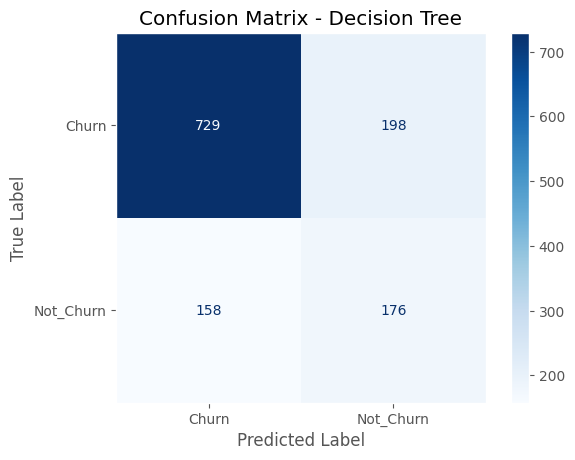

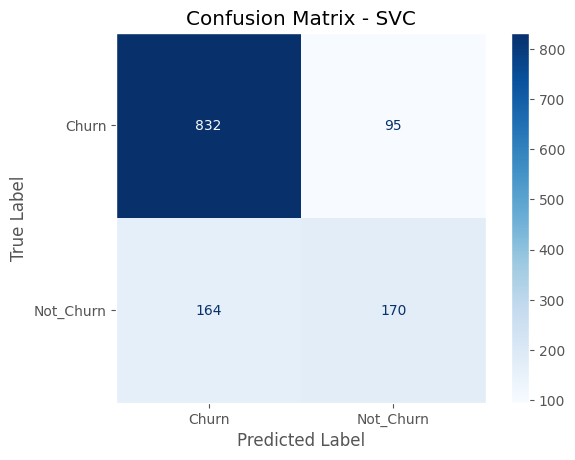

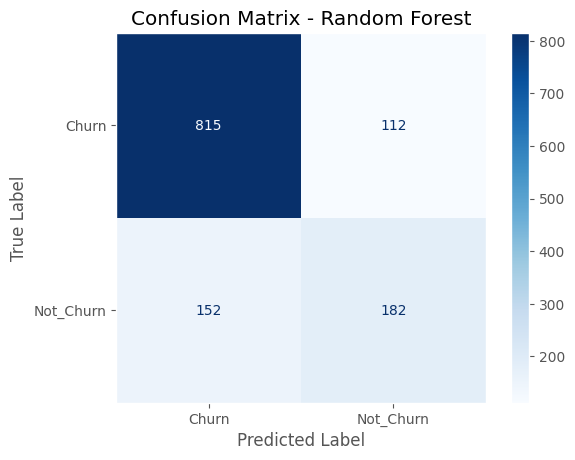

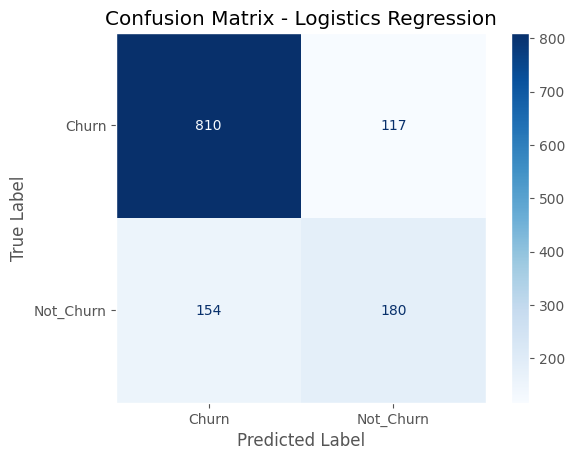

In [75]:
for model_name, classifier in models:
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])
    pipeline.fit(X_train, y_train_encoded)
    y_pred = pipeline.predict(X_test)

    # Compute confusion matrix
    cm = confusion_matrix(y_test_encoded, y_pred)

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Churn', 'Not_Churn'])
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.grid(False)
    plt.show()

2. ROC Curve and AUC Score

In [76]:
from sklearn.metrics import roc_curve, auc, roc_auc_score, RocCurveDisplay

# Generate Prediction Probabilities
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]


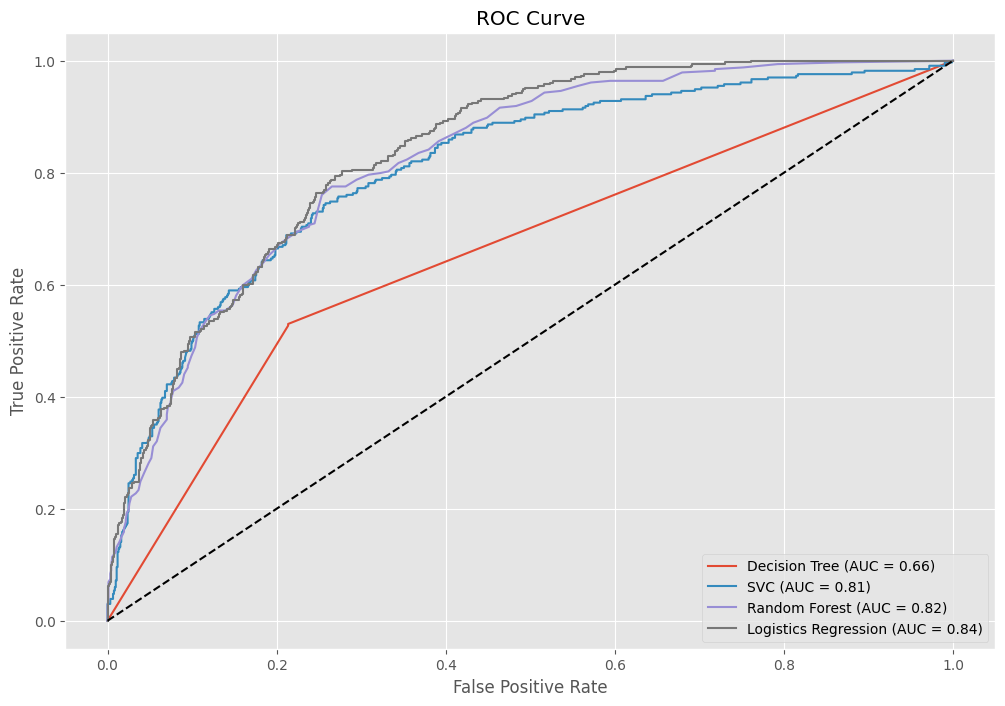

In [77]:
def plot_roc_curve(models, X_test, y_test):
    plt.figure(figsize=(12, 8))
    
    for model_name, classifier in models:
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', classifier)
        ])
        pipeline.fit(X_train, y_train_encoded)
        y_prob = pipeline.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class
        fpr, tpr, _ = roc_curve(y_test_encoded, y_prob)
        auc = roc_auc_score(y_test_encoded, y_prob)
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.2f})')
        
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

plot_roc_curve(models, X_test, y_test_encoded)

Understanding AUC Scores

AUC (Area Under the Curve): The AUC score represents the area under the ROC curve, which plots the true positive rate (recall) against the false positive rate. The AUC score ranges from 0 to 1, where:
0.5 represents a model with no discriminative ability (equivalent to random guessing).
1.0 represents a perfect model.
AUC close to 1 indicates excellent model performance.
AUC less than 0.5 indicates a poor model.

Decision Tree (AUC = 0.66):
    - This is a relatively low AUC, suggesting that the decision tree model has limited ability to distinguish between the classes (churn vs. non-churn)

Support Vector Machine (SVC) (AUC = 0.81):

    - A solid AUC score, indicating that the SVC model has a good ability to discriminate between churners and non-churners. It suggests a well-performing model.

Random Forest (AUC = 0.81):

    - Similar to SVC, the Random Forest model also shows good performance with an AUC of 0.81. This suggests that the ensemble method is effectively capturing the relationship between the features and the churn outcome.

Logistic Regression (AUC = 0.84):

    -Logistic regression appears to be the best performer in this case, indicating strong discriminative power for identifying churners.

3. Precision-Recall Curve

In [78]:
from sklearn.metrics import precision_recall_curve, average_precision_score, PrecisionRecallDisplay

y_pred_proba = pipeline.predict_proba(X_test)[:, 1]  # Probability of positive class

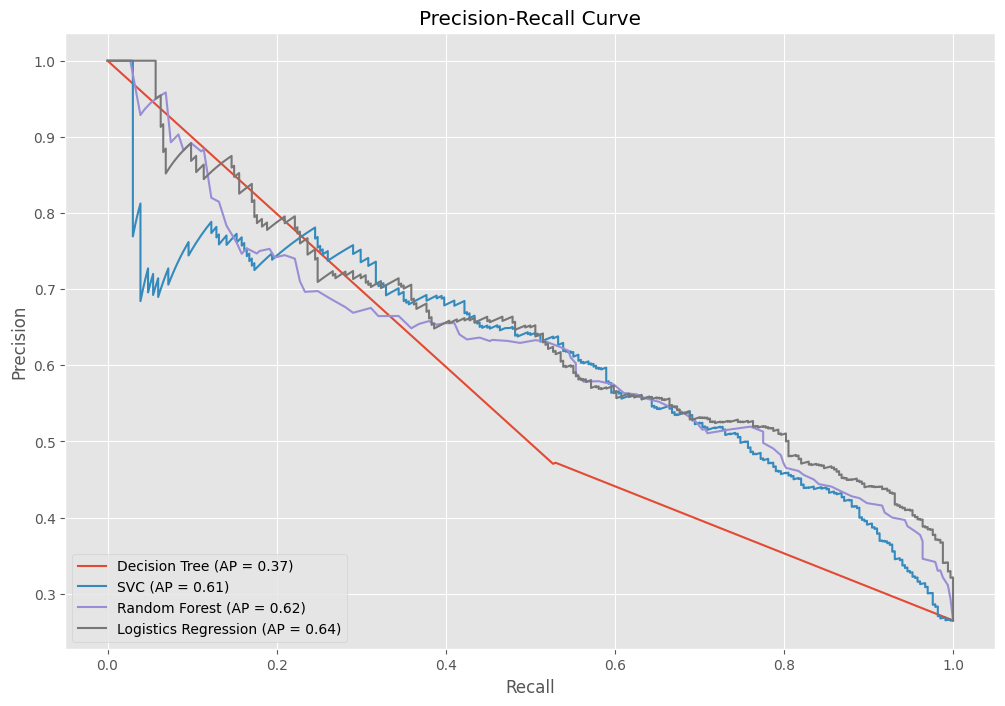

In [79]:
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_precision_recall_curve(models, X_test, y_test):
    plt.figure(figsize=(12, 8))
    
    for model_name, classifier in models:
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', classifier)
        ])
        pipeline.fit(X_train, y_train_encoded)
        y_prob = pipeline.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class
        precision, recall, _ = precision_recall_curve(y_test_encoded, y_prob)
        avg_precision = average_precision_score(y_test_encoded, y_prob)
        plt.plot(recall, precision, label=f'{model_name} (AP = {avg_precision:.2f})')
        
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.show()

plot_precision_recall_curve(models, X_test, y_test_encoded)


Understanding AP Scores

Average Precision (AP): This score summarizes the precision-recall curve by computing the weighted mean of precisions achieved at each threshold, with the increase in recall from the previous threshold used as the weight. The AP score ranges from 0 to 1, where:
0 represents a model that performs as poorly as possible (precision is zero at all recall levels).
1 represents a perfect model (high precision for every recall level).
Higher AP indicates better performance in distinguishing between positive (churn) and negative (non-churn) classes, particularly in scenarios with class imbalance.

Decision Tree (AP = 0.37):

    - This is the lowest AP score among the models. It suggests that the Decision Tree model has limited ability to maintain high precision across different recall levels. It might produce many false positives, especially at higher recall levels.

Support Vector Machine (SVC) (AP = 0.61):

    - This score indicates a fairly good performance. The SVC model maintains a decent balance between precision and recall, suggesting it handles class imbalance reasonably well.

Random Forest (AP = 0.62):

    - Similar to SVC, the Random Forest model shows good performance with an AP score of 0.62. This indicates that it can effectively maintain precision while identifying true positives (churners).

Logistic Regression (AP = 0.64):

    - The highest AP score among your models. most effective model in terms of handling class imbalance and reducing false positives.


####    b. Feature Importance and Selection

1. Using Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd



# Fit the Random Forest model to get feature importances
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train_encoded)

# Get feature importances
importances = rf_model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print or visualize feature importances
feature_importance_df


In [ ]:
from sklearn.linear_model import LogisticRegression
import pandas as pd

# Assuming X_train and y_train_encoded are already defined and preprocessed

# Train a Logistic Regression model
log_reg_model = LogisticRegression(random_state=42, max_iter=1000)
log_reg_model.fit(X_train, y_train_encoded)

# Get coefficients and feature names
coefficients = log_reg_model.coef_[0]
feature_names = X_train.columns

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
feature_importance_df['Importance'] = feature_importance_df['Coefficient'].abs()

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print or visualize feature importances
print(feature_importance_df[['Feature', 'Coefficient', 'Importance']])

